In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 1400  #novel number
t = 'Great_Expectations'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
with open('data/novel_'+novel_title+'.csv', 'wb') as f:
    writer = csv.writer(f)
    for sentence in novel_sentences:
        writer.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,"So, I called myself Pip, and came to be called..."
1,"I give Pirrip as my father's family name, on t..."
2,"As I never saw my father or my mother, and nev..."
3,"The shape of the letters on my father's, gave ..."
4,From the character and turn of the inscription...


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]"
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,"[1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 4, 1, 1, 2, ..."
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,"[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, ..."
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,"[1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 3, 1, ..."
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,"[1, 1, 3, 1, 1, 1, 1, 3, 2, 4, 1, 1, 1, 2, 1, ..."


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create csv file to record syllable count per word. 

In [18]:
d = {}
for l in df_novel[0]:
    sent = TextBlob(l)
    for x in sent.words:
        w = CountSyllables(x)
        d[x] = w

In [19]:
with open('data/novel_'+novel_title+'_syl.csv', 'wb') as f:
    writer = csv.writer(f)
    for row in d.iteritems():
        writer.writerow(row)

Create syllable sum column

In [20]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [21]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [22]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [23]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Create cluster dataframe - remove columns that can't be used

In [24]:
df_cluster = df_novel.drop('wrd_length', 1)

In [25]:
df_cluster = df_cluster.drop('syl_count', 1)

In [26]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"So, I called myself Pip, and came to be called...",38,12,0.000000
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000
2,"As I never saw my father or my mother, and nev...",192,63,0.100000
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111
4,From the character and turn of the inscription...,122,40,-0.304762


Create 20 clusters on scaled data

In [27]:
X = df_cluster.drop(0, axis=1)

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [30]:
df_cluster_20 = df_cluster.copy()

In [31]:
df_cluster_20['cluster'] = km.labels_

In [32]:
df_cluster_20.head()

,0,total_char,syl_sum,sentiment,cluster
0,"So, I called myself Pip, and came to be called...",38,12,0.000000,1
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000,18
2,"As I never saw my father or my mother, and nev...",192,63,0.100000,7
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111,4
4,From the character and turn of the inscription...,122,40,-0.304762,4


In [33]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"So, I called myself Pip, and came to be called...",38,12,0.000000
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000
2,"As I never saw my father or my mother, and nev...",192,63,0.100000
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111
4,From the character and turn of the inscription...,122,40,-0.304762


In [34]:
df_cluster_20.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,41.165501,13.062937,0.238777
1,40.539201,12.852811,0.000073
2,242.000000,77.892473,0.235276
3,216.391304,69.247492,-0.077036
4,96.250000,30.917500,-0.201188
5,501.350000,159.500000,0.024646
6,111.963738,35.732218,0.012277
7,165.581818,53.257143,0.183285
8,147.845411,47.946860,0.536608


In [35]:
centers = df_cluster_20.groupby('cluster').mean()

Create Scatter plot 

In [36]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

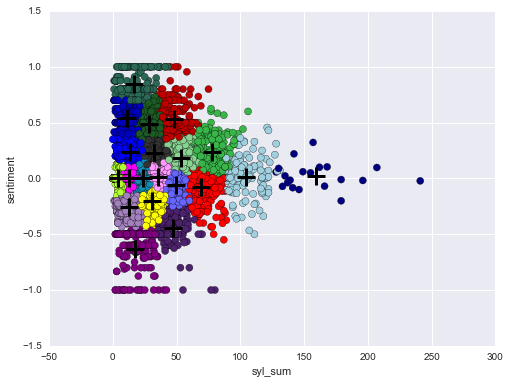

In [37]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster_20.syl_sum, df_cluster_20.sentiment, c=colors[df_cluster_20.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Add cluster_20 to original dataframe

In [38]:
df_novel['cluster_20'] = df_cluster_20['cluster']

In [39]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]",12,0.000000,1
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,"[1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 4, 1, 1, 2, ...",35,0.250000,18
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,"[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, ...",63,0.100000,7
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,"[1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 3, 1, ...",30,-0.161111,4
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,"[1, 1, 3, 1, 1, 1, 1, 3, 2, 4, 1, 1, 1, 2, 1, ...",40,-0.304762,4


Create 3 clusters

In [40]:
df_cluster_3 = df_cluster.copy()

In [41]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment
0,"So, I called myself Pip, and came to be called...",38,12,0.000000
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000
2,"As I never saw my father or my mother, and nev...",192,63,0.100000
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111
4,From the character and turn of the inscription...,122,40,-0.304762


In [42]:
X = df_cluster_3.drop(0, axis=1)

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [45]:
df_cluster_3['cluster'] = km.labels_

In [46]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,43.644909,13.856846,-0.032012
1,79.406122,25.546939,0.473081
2,179.686632,57.622425,0.011268


In [47]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,"So, I called myself Pip, and came to be called...",38,12,0.000000,0
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000,1
2,"As I never saw my father or my mother, and nev...",192,63,0.100000,2
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111,0
4,From the character and turn of the inscription...,122,40,-0.304762,2


Add cludter_3 to original dataframe

In [48]:
df_novel['cluster_3_syl'] = df_cluster_3['cluster']

In [49]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]",12,0.000000,1,0
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,"[1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 4, 1, 1, 2, ...",35,0.250000,18,1
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,"[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, ...",63,0.100000,7,2
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,"[1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 3, 1, ...",30,-0.161111,4,0
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,"[1, 1, 3, 1, 1, 1, 1, 3, 2, 4, 1, 1, 1, 2, 1, ...",40,-0.304762,4,2


Create 3 Clusters with no syl_sum

In [50]:
df_cluster_3no_syl = df_cluster.copy()

In [51]:
df_cluster_3no_syl = df_cluster.drop('syl_sum', 1)

In [52]:
X = df_cluster_3no_syl.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_3no_syl['cluster'] = km.labels_

In [56]:
df_cluster_3no_syl.head()

,0,total_char,sentiment,cluster
0,"So, I called myself Pip, and came to be called...",38,0.000000,0
1,"I give Pirrip as my father's family name, on t...",108,0.250000,2
2,"As I never saw my father or my mother, and nev...",192,0.100000,1
3,"The shape of the letters on my father's, gave ...",93,-0.161111,0
4,From the character and turn of the inscription...,122,-0.304762,1


In [57]:
df_cluster_3no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,44.307937,-0.034823
1,179.600195,0.013025
2,79.655219,0.478504


Add cluster_3no_syl to original dataframe

In [58]:
df_novel['cluster_3no_syl'] = df_cluster_3no_syl['cluster']

In [59]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]",12,0.000000,1,0,0
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,"[1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 4, 1, 1, 2, ...",35,0.250000,18,1,2
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,"[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, ...",63,0.100000,7,2,1
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,"[1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 3, 1, ...",30,-0.161111,4,0,0
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,"[1, 1, 3, 1, 1, 1, 1, 3, 2, 4, 1, 1, 1, 2, 1, ...",40,-0.304762,4,2,1


Create 5 Clusters

In [60]:
df_cluster_5 = df_cluster.copy()

In [61]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment
0,"So, I called myself Pip, and came to be called...",38,12,0.000000
1,"I give Pirrip as my father's family name, on t...",108,35,0.250000
2,"As I never saw my father or my mother, and nev...",192,63,0.100000
3,"The shape of the letters on my father's, gave ...",93,30,-0.161111
4,From the character and turn of the inscription...,122,40,-0.304762


In [62]:
X = df_cluster_5.drop(0, axis=1)

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [64]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [65]:
df_cluster_5['cluster'] = km.labels_

In [66]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,31.189449,9.845928,0.011375
1,121.532173,38.908134,0.044516
2,73.291782,23.571560,0.547612
3,74.249344,23.883202,-0.366397
4,246.521918,79.090411,0.055007


Add cluster_5 to original dataframe

In [67]:
df_novel['cluster_5'] = df_cluster_5['cluster']

In [68]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]",12,0.000000,1,0,0,0
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,"[1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 4, 1, 1, 2, ...",35,0.250000,18,1,2,1
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,"[1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, ...",63,0.100000,7,2,1,4
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,"[1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 3, 1, ...",30,-0.161111,4,0,0,3
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,"[1, 1, 3, 1, 1, 1, 1, 3, 2, 4, 1, 1, 1, 2, 1, ...",40,-0.304762,4,2,1,3


Write files to csv

In [69]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [70]:
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [71]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,"So, I called myself Pip, and came to be called...","[2, 1, 6, 6, 3, 3, 4, 2, 2, 6, 3]",38,[1 1 1 2 1 1 1 1 1 1 1],12,0.000000,1,0,0,0
1,"I give Pirrip as my father's family name, on t...","[1, 4, 6, 2, 2, 6, 2, 6, 4, 2, 3, 9, 2, 3, 9, ...",108,[1 1 2 1 1 2 0 3 1 1 1 4 1 1 2 1 1 2 0 0 3 1 2...,35,0.250000,18,1,2,1
2,"As I never saw my father or my mother, and nev...","[2, 1, 5, 3, 2, 6, 2, 2, 6, 3, 5, 3, 3, 8, 2, ...",192,[1 1 2 1 1 2 1 1 2 1 2 1 2 3 1 2 1 1 1 1 1 1 1...,63,0.100000,7,2,1,4
3,"The shape of the letters on my father's, gave ...","[3, 5, 2, 3, 7, 2, 2, 6, 2, 4, 2, 2, 3, 4, 4, ...",93,[1 1 1 1 2 1 1 2 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1...,30,-0.161111,4,0,0,3
4,From the character and turn of the inscription...,"[4, 3, 9, 3, 4, 2, 3, 11, 4, 9, 4, 2, 3, 5, 1,...",122,[1 1 3 1 1 1 1 3 2 4 1 1 1 2 1 1 1 2 3 1 1 2 1...,40,-0.304762,4,2,1,3


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [72]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
9818,"I have been bent and broken, but--I hope--into...","[1, 4, 4, 4, 3, 6, 3, 1, 4, 4, 1, 6, 5]",46,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1]",16,0.0500,1,0,0,0
9819,"Be as considerate and good to me as you were, ...","[2, 2, 11, 3, 4, 2, 2, 2, 3, 4, 3, 4, 2, 2, 3, 7]",56,"[1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]",20,0.7000,14,1,2,2
9820,"""We are friends,"" said I, rising and bending o...","[2, 3, 7, 4, 1, 6, 3, 7, 4, 3, 2, 3, 4, 4, 3, 5]",61,"[1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1]",19,0.6000,10,1,2,2
9821,"""And will continue friends apart,"" said Estella.","[3, 4, 8, 7, 5, 4, 7]",38,"[1, 1, 2, 2, 2, 1, 3]",12,0.0000,1,0,0,0
9822,"I took her hand in mine, and we went out of th...","[1, 4, 3, 4, 2, 4, 3, 2, 4, 3, 2, 3, 6, 5, 3, ...",220,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",70,0.1325,2,2,1,4


In [73]:
df_novel['total_char'].sum()

765212

In [74]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - (.06 * (int(len(df_novel) - 1)))
# or figure out some better code. 
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [75]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:489]
df_novel['total_char'][489:989]
df_novel['total_char'][989:1517]
df_novel['total_char'][1517:2016]
df_novel['total_char'][2016:2488]
df_novel['total_char'][2488:3004]
df_novel['total_char'][3004:3472]
df_novel['total_char'][3472:3942]
df_novel['total_char'][3942:4434]
df_novel['total_char'][4434:4929]
df_novel['total_char'][4929:5403]
df_novel['total_char'][5403:5821]
df_novel['total_char'][5821:6260]
df_novel['total_char'][6260:6841]
df_novel['total_char'][6841:7357]
df_novel['total_char'][7357:7791]
df_novel['total_char'][7791:8312]
df_novel['total_char'][8312:8815]
df_novel['total_char'][8815:9238]
df_novel['total_char'][9238:9686]


In [76]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
489
0.0155775145249
489
989
0.0409993449421
989
1517
0.0360117613361
1517
2016
0.0433742101034
2016
2488
0.0616488856943
2488
3004
0.0688883505086
3004
3472
0.0413024552126
3472
3942
0.0819286853464
3942
4434
0.0663532569522
4434
4929
0.0725444867235
4929
5403
0.0556928738358
5403
5821
0.0552741801991
5821
6260
0.0592340858768
6260
6841
0.0435564316755
6841
7357
0.0142173653892
7357
7791
0.0762170026422
7791
8312
0.0457206971987
8312
8815
0.0468001620265
8815
9238
0.047998991093
9238
9686
0.0799488233517


In [77]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.01557751  0.04099934  0.03601176  0.04337421  0.06164889  0.06888835
  0.04130246  0.08192869  0.06635326  0.07254449  0.05569287  0.05527418
  0.05923409  0.04355643  0.01421737  0.076217    0.0457207   0.04680016
  0.04799899  0.07994882]


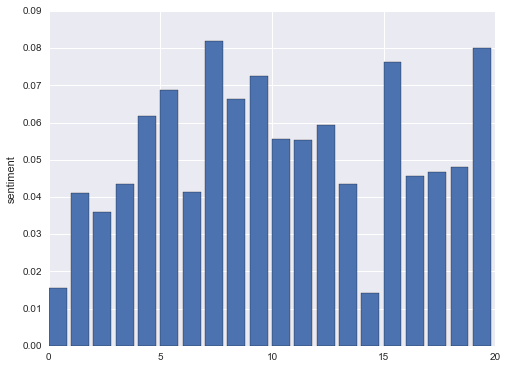

In [78]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [79]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
9818,"I have been bent and broken, but--I hope--into...","[1, 4, 4, 4, 3, 6, 3, 1, 4, 4, 1, 6, 5]",46,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1]",16,0.0500,1,0,0,0
9819,"Be as considerate and good to me as you were, ...","[2, 2, 11, 3, 4, 2, 2, 2, 3, 4, 3, 4, 2, 2, 3, 7]",56,"[1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]",20,0.7000,14,1,2,2
9820,"""We are friends,"" said I, rising and bending o...","[2, 3, 7, 4, 1, 6, 3, 7, 4, 3, 2, 3, 4, 4, 3, 5]",61,"[1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1]",19,0.6000,10,1,2,2
9821,"""And will continue friends apart,"" said Estella.","[3, 4, 8, 7, 5, 4, 7]",38,"[1, 1, 2, 2, 2, 1, 3]",12,0.0000,1,0,0,0
9822,"I took her hand in mine, and we went out of th...","[1, 4, 3, 4, 2, 4, 3, 2, 4, 3, 2, 3, 6, 5, 3, ...",220,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",70,0.1325,2,2,1,4


In [80]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) - (.06 * (int(len(df_novel) - 1)))
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [81]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(0, 3):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:3339]
df_novel['total_char'][3339:6569]
df_novel['total_char'][6569:9796]


In [82]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
3339
0.0466163319052
3339
6569
0.0599800498812
6569
9796
0.0516811945169


In [83]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.04661633  0.05998005  0.05168119]


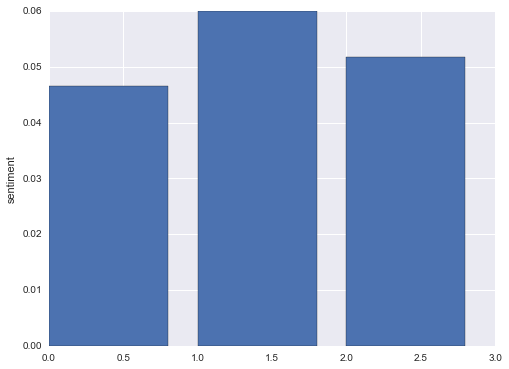

In [84]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers